# Introduction to single-cell multi-view profiler (scMVP)
In this introductory tutorial, we present the different tasks of a scMVP workflow
1. Loading the multi-omics data
2. Training the multi-view model
3. Retrieving the common latent space and imputed multi-omics values
4. Perform cell clustering and differential expression 
5. Visualize the common latent space and clustering with umap
6. The differential gene cluster identification

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.use('WXAgg')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scvi.dataset import scienceDataset
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer
from scvi.inference import MultiPosterior, MultiTrainer
import torch
from scvi.models.multi_vae import Multi_VAE

## Visualizing the latent space with scanpy
import scanpy as sc
import anndata


E:\Users\A502\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "E:\Users\A502\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "E:\Users\A502\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "E:\Users\A502\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "E:\Users\A502\Anaconda3\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "E:\Users\A502\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 563, in start
    self.io_loop.start()
  File "E:\Users\A502\Anaconda

## Loading data

 loading the sci-CAR cell line dataset described in Junyue Cao et al. (2018).

* Junyue Cao, et al. "Joint profiling of chromatin accessibility and gene 
expression in thousands of single cells." Science 361.6409 (2018): 1380-1385. 

In [14]:
def allow_mmvae_for_test():
    print("Testing the basic tutorial scMVP")

test_mode = False
save_path = "data/"
n_epochs_all = None
show_plot = True

if not test_mode:
    save_path = "E:/data/qiliu/single-cell program/ATAC/science data/"

dataset = scienceDataset(dataset_name="CellLineMixture", save_path=save_path, measurement_names_column=1, is_binary = True)

[2021-01-21 23:43:50,711] INFO - scvi.dataset.scienceDataset | Preprocessing dataset
E:\Users\A502\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
[2021-01-21 23:44:15,450] INFO - scvi.dataset.scienceDataset | Finished preprocessing dataset
[2021-01-21 23:44:46,681] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-01-21 23:44:49,626] INFO - scvi.dataset.dataset | Downsampled from 4825 to 4825 cells


## data filtering 

In [15]:
def filter_dataset(dataset):
    high_count_genes = (dataset.X > 0).sum(axis=0).ravel() > 0.01 * dataset.X.shape[0]
    dataset.update_genes(high_count_genes)
    dataset.subsample_genes(new_n_genes=10000)
    
    high_gene_count_cells = (dataset.X > 0).sum(axis=1).ravel() > 50
    #high_atac_cells = dataset.atac_expression.sum(axis=1) >= np.percentile(dataset.atac_expression.sum(axis=1), 10)
    high_atac_cells = dataset.atac_expression.sum(axis=1) >= np.percentile(dataset.atac_expression.sum(axis=1), 1)
    inds_to_keep = np.logical_and(high_gene_count_cells, high_atac_cells)
    dataset.update_cells(inds_to_keep)
    return dataset, inds_to_keep

if test_mode is False:
    dataset, inds_to_keep = filter_dataset(dataset)


[2021-01-21 23:44:51,702] INFO - scvi.dataset.dataset | Downsampling from 113153 to 20403 genes
[2021-01-21 23:44:53,547] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-01-21 23:44:54,848] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2021-01-21 23:44:58,544] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-01-21 23:44:58,887] INFO - scvi.dataset.dataset | Downsampled from 4825 to 4825 cells
[2021-01-21 23:45:02,486] INFO - scvi.dataset.dataset | Downsampling from 20403 to 10000 genes
[2021-01-21 23:45:03,371] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-01-21 23:45:03,972] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2021-01-21 23:45:06,046] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-01-21 23:45:06,204] INFO - scvi.dataset.dataset | Downsampled from 4825 to 4825 cells
[2021-01-21 23:45:08,549] INFO - scvi.dataset.dat

* __n_epochs__: Maximum number of epochs to train the model. If the likelihood change is small than a set threshold training will stop automatically. 
* __lr__: learning rate. Set to 0.001 here. 
* __use_batches__: If the value of true than batch information is used in the training. Here it is set to false because the cortex data only contains one batch. 
* __use_cuda__: Set to true to use CUDA (GPU required) 
* __n_centroids__: Set the number of cell types
* __n_alfa__: Set the weight of KL loss

In [16]:
n_epochs = 30 if n_epochs_all is None else n_epochs_all
lr = 1e-3
use_batches = False
use_cuda = True
n_centroids = 5
n_alfa = 1.0

## Pre-training
runing pre-train vae to initialize the Gaussian Mixture Model

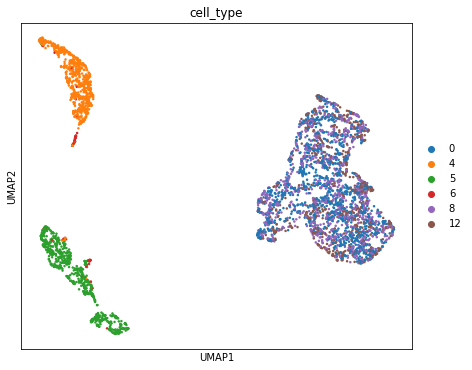

In [17]:
pre_vae = VAE(dataset.nb_genes, n_batch=256)
pre_trainer = UnsupervisedTrainer(
    pre_vae,
    dataset,
    train_size=0.75,
    use_cuda=use_cuda,
    frequency=5
)
is_test_pragram = False
if is_test_pragram:
    pre_trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(pre_trainer.model.state_dict(), '%s/pre_trainer6.pkl' % save_path)

if os.path.isfile('%s/pre_trainer6.pkl' % save_path):
    pre_trainer.model.load_state_dict(torch.load('%s/pre_trainer6.pkl' % save_path))
    pre_trainer.model.eval()
else:
    #pre_trainer.model.init_gmm_params(dataset)
    pre_trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(pre_trainer.model.state_dict(), '%s/pre_trainer6.pkl' % save_path)

# pretrainer_posterior:
full = pre_trainer.create_posterior(pre_trainer.model, dataset, indices=np.arange(len(dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()

# visulization
prior_adata = anndata.AnnData(X=dataset.X)
prior_adata.obsm["X_multi_vi"] = latent
prior_adata.obs['cell_type'] = pd.Categorical(labels.astype(int))
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=15)
sc.tl.umap(prior_adata, min_dist=0.1)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(prior_adata, color=["cell_type"], ax=ax, show=show_plot)

# Training scMVP
We now create the scMVP model and the trainer object.

If a pre-trained model already exist in the save_path then load the same model rather than re-training it. This is particularly useful for large datasets.

In [18]:
multi_vae = Multi_VAE(dataset.nb_genes, len(dataset.atac_names), n_batch=256, n_centroids=n_centroids, n_alfa = n_alfa, mode="mm-vae") # should provide ATAC num, alfa, mode and loss type
trainer = MultiTrainer(
    multi_vae,
    dataset,
    train_size=0.75,
    use_cuda=use_cuda,
    frequency=5,
)

clust_index_gmm = trainer.model.init_gmm_params(latent)

is_test_pragram = False
if is_test_pragram:
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/multi_vae_210121.pkl' % save_path)
if os.path.isfile('%s/multi_vae_210121.pkl' % save_path):
    trainer.model.load_state_dict(torch.load('%s/multi_vae_210121.pkl' % save_path))
    trainer.model.eval()
else:
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/multi_vae_210121.pkl' % save_path)

Plotting the likelihood change across the n epochs of training: blue for training error and orange for testing error.**

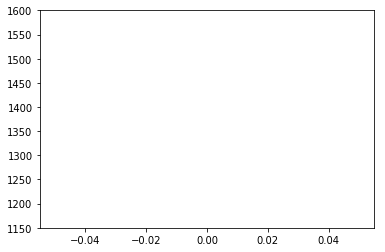

In [19]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 500, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
plt.ylim(1150, 1600)
plt.show()

query the imputed values via the `imputation` method of the posterior object and get common latent embedding. **Note for advanced users:** imputation is an ambiguous term and there are two ways to perform imputation in scVI. The first way is to query the **mean of the negative binomial** distribution modeling the counts. This is referred to as `sample_rate` in the codebase and can be reached via the `imputation` method. The second is to query the **normalized mean of the same negative binomial** (please refer to the scVI manuscript). This is referred to as `sample_scale` in the codebase and can be reached via the `get_sample_scale` method. In differential expression for example, we of course rely on the normalized latent variable which is corrected for variations in sequencing depth.

In [20]:
full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
imputed_values = full.sequential().imputation()
latent, latent_rna, latent_atac, cluster_gamma, cluster_index, batch_indices, labels = full.sequential().get_latent()

sample_latents = torch.tensor([])
sample_labels = torch.tensor([])
rna_imputation = imputed_values[0]
atac_imputation = imputed_values[3]
temp_label = []
sample_latents = torch.tensor([])
samples = torch.tensor([])
sample_labels = torch.tensor([])
if len(imputed_values) >= 3:
    temp_label = imputed_values[2]
for tensors_list in range(int(len(imputed_values[0])/256)+1):
    if temp_label.any():
        temp_samples = trainer.model.get_latents(x_rna=torch.tensor(rna_imputation[tensors_list*256:(1+tensors_list)*256,:]),
                                                x_atac=torch.tensor(atac_imputation[tensors_list*256:(1+tensors_list)*256,:]),
                                                y=torch.tensor(temp_label[tensors_list*256:(1+tensors_list)*256])) 
    else:
        temp_samples = trainer.model.get_latents(x_rna=torch.tensor(rna_imputation[tensors_list*256:(1+tensors_list)*256,:]),
                                                x_atac=torch.tensor(atac_imputation[tensors_list*256:(1+tensors_list)*256,:]),
                                                y=torch.tensor(np.zeros(256))) 
    for temp_sample in temp_samples:
        #sample_latents = torch.cat((sample_latents, temp_sample[2].float()))
        sample_latents = torch.cat((sample_latents, temp_sample[0][0].float()))
        sample_labels = torch.cat((sample_labels, torch.tensor(temp_label[tensors_list*256:(1+tensors_list)*256]).float()))

## cell clustering
cell clustering and merging the rare clusters which less than 10 cells

In [21]:
clust_index_gmm = trainer.model.init_gmm_params(latent)
gmm_clus_index = clust_index_gmm.reshape(-1,1)
for i in range(len(np.unique(gmm_clus_index))):
    if len(gmm_clus_index[gmm_clus_index == i]) <= 10:
        for j in range(len(np.unique(gmm_clus_index))):
            if len(gmm_clus_index[gmm_clus_index == j]) > 100:
                gmm_clus_index[gmm_clus_index == i] = j
                break
unique_gmm_clus_index = np.unique(gmm_clus_index)
for i in range(len(unique_gmm_clus_index)):
    gmm_clus_index[gmm_clus_index == unique_gmm_clus_index[i]] = i

Visualizing common latent embedding and cell clustering by scMVP

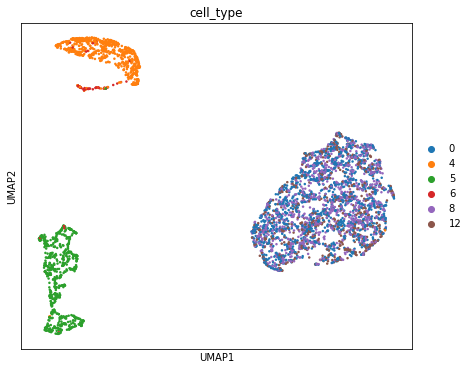

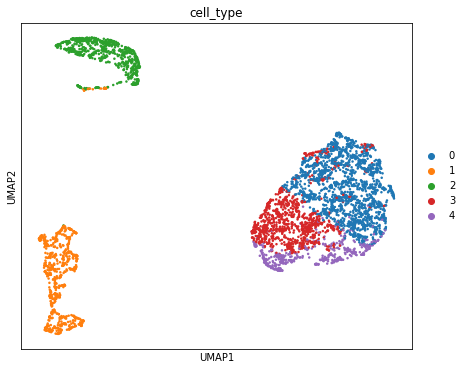

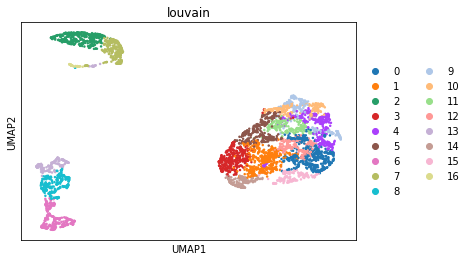

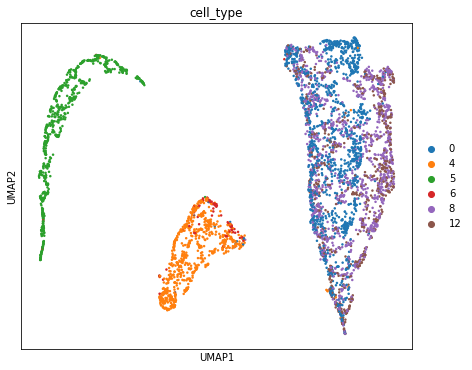

In [22]:
posterior_adata = anndata.AnnData(X=rna_imputation)
posterior_adata.obsm["X_multi_vi"] = latent
posterior_adata.obs['cell_type'] = pd.Categorical(labels)
sc.pp.neighbors(posterior_adata, use_rep="X_multi_vi", n_neighbors=15)
sc.tl.umap(posterior_adata, min_dist=0.1)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(posterior_adata, color=["cell_type"], ax=ax, show=show_plot)
# imputation labels
'''
posterior_adata.obs['cell_type'] = pd.Categorical(clust_index_gmm)
sc.pp.neighbors(posterior_adata, use_rep="X_multi_vi", n_neighbors=15)
sc.tl.umap(posterior_adata, min_dist=0.1)
#matplotlib.use('TkAgg')
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(posterior_adata, color=["cell_type"], ax=ax, show=show_plot)
sc.tl.louvain(posterior_adata)
sc.pl.umap(posterior_adata, color=['louvain'])

posterior_adata = anndata.AnnData(X=rna_imputation)
posterior_adata.obsm["X_multi_vi"] = sample_latents.detach().numpy()
posterior_adata.obs['cell_type'] = pd.Categorical(labels)
sc.pp.neighbors(posterior_adata, use_rep="X_multi_vi", n_neighbors=15)
sc.tl.umap(posterior_adata, min_dist=0.1)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(posterior_adata, color=["cell_type"], ax=ax, show=show_plot)
'''

## differential gene analysis
differential gene identification 

... storing 'louvain' as categorical


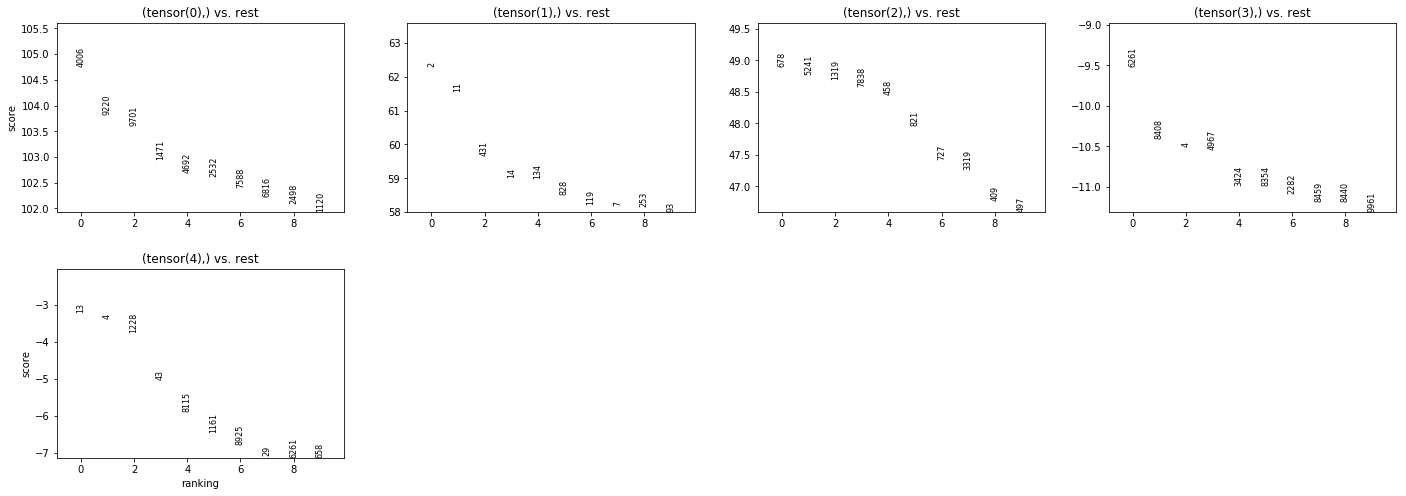

In [23]:
posterior_adata.obs['louvain'] = torch.tensor(gmm_clus_index.reshape(-1,1))
sc.tl.rank_genes_groups(posterior_adata, 'louvain')
sc.pl.rank_genes_groups(posterior_adata, n_genes=10, sharey=False)
diff_top_gene_set = posterior_adata.uns['rank_genes_groups']
diff_top_gene_set = (diff_top_gene_set['names'])
diff_top_gene_pvalue_set = posterior_adata.uns['rank_genes_groups']
diff_top_gene_pvalue_set = (diff_top_gene_pvalue_set['pvals_adj'])
diff_top_gene_foldchange_set = posterior_adata.uns['rank_genes_groups']
diff_top_gene_foldchange_set = (diff_top_gene_foldchange_set['logfoldchanges'])

differential ATAC peaks analysis

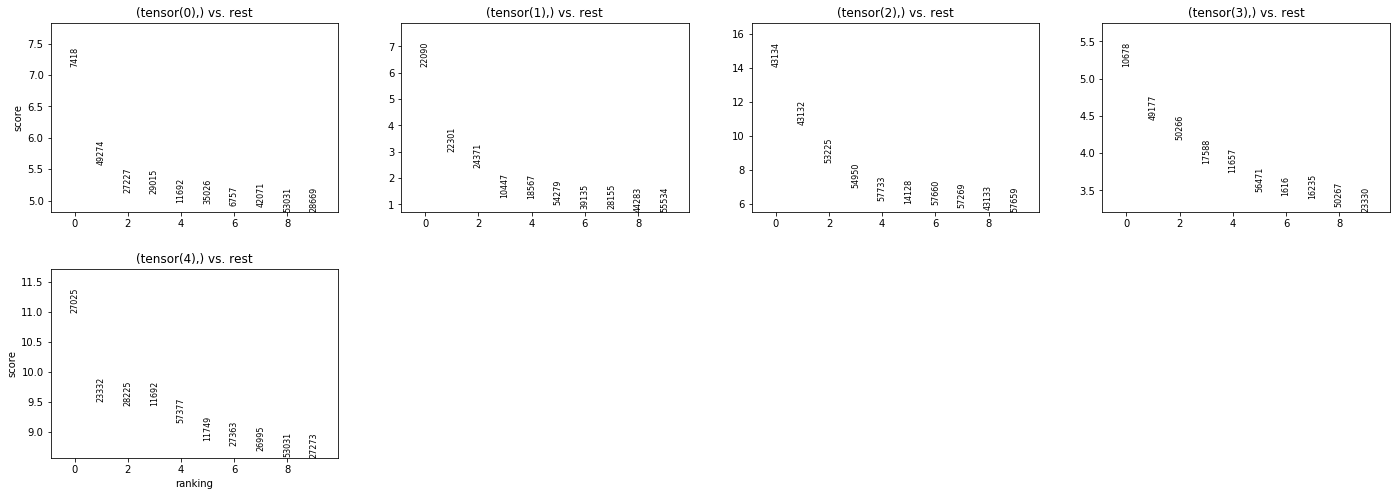

In [24]:
atac_posterior_adata = anndata.AnnData(X=atac_imputation)
atac_posterior_adata.obs['louvain'] = posterior_adata.obs['louvain']
sc.tl.rank_genes_groups(atac_posterior_adata, 'louvain',n_genes=1000)
sc.pl.rank_genes_groups(atac_posterior_adata, n_genes=10, sharey=False)
atac_diff_top_gene_set = atac_posterior_adata.uns['rank_genes_groups']
atac_diff_top_gene_set = (atac_diff_top_gene_set['names'])
atac_diff_top_gene_pvalue_set = atac_posterior_adata.uns['rank_genes_groups']
atac_diff_top_gene_pvalue_set = (atac_diff_top_gene_pvalue_set['pvals_adj'])
atac_diff_top_gene_foldchange_set = atac_posterior_adata.uns['rank_genes_groups']
atac_diff_top_gene_foldchange_set = (atac_diff_top_gene_foldchange_set['logfoldchanges'])